# The airplane problem

## Problem description

A cargo airplane has three compartments for storing freight: Front, central and rear.


Each one of those compartments has the following limitations in weight and space:

In [27]:
import pandas as pd

compartment_limits = pd.DataFrame(columns=['Weight (ton)', 'Volume (meter cube)'])
compartment_limits.loc['Front']  = [8,  12000]
compartment_limits.loc['Center'] = [12, 10000]
compartment_limits.loc['Rear']   = [14, 6000]
compartment_limits

,Weight (ton),Volume (meter cube)
Front,8,12000
Center,12,10000
Rear,14,6000


The following maximum cargo is available to be transported from a warehouse:


In [28]:
cargo_limits = pd.DataFrame(columns=['Weight limit (ton)', 'Volume per ton (meter cube)'])
cargo_limits.loc['Type 1'] = [18, 180]
cargo_limits.loc['Type 2'] = [14, 250]
cargo_limits.loc['Type 3'] = [20, 300]
cargo_limits.loc['Type 4'] = [12, 80]
cargo_limits

,Weight limit (ton),Volume per ton (meter cube)
Type 1,18,180
Type 2,14,250
Type 3,20,300
Type 4,12,80


The profit associated to transporting one ton is 590 m.u., 580 m.u., 580 m.u. and 600 m.u., respectively for cargo types 1, 2, 3 and 4.


In [29]:
cargo_limits['Profit'] = [590, 580, 580, 600]
cargo_limits

,Weight limit (ton),Volume per ton (meter cube),Profit
Type 1,18,180,590
Type 2,14,250,580
Type 3,20,300,580
Type 4,12,80,600


Build a mathematical model to define the amount of cargo of each type that should be transported and how it should be distributed in order to be efficient during the flight. The objective is to maximize the profit while satisfying the operational constraints mentioned.

## Modeling


Let's first create multidicts to efficiently store compartment and cargo limits.

In [30]:
import gurobipy as gp

model = gp.Model()

In [31]:
# cargo limits
cargo_type, cargo_weight, cargo_volume, cargo_profit = gp.multidict({
    'Type1': [18, 180, 590],
    'Type2': [14, 250, 580],
    'Type3': [20, 300, 580],
    'Type4': [12, 80,  600]
})

# compartment limits
compartment_type, compartment_weight, compartment_volume = gp. multidict({
    'Front': [8,  12000],
    'Center':[12, 10000],
    'Rear':  [14, 6000]
})

### Decision variables

$x_{ij}$: binary variable. 1 if road inspector at nore $i$ handles incident $j$.  $i$ in $I$ & $j$ in $J$

In [32]:
## decision variables
x = model.addVars(len(cargo_type),len(compartment_type), vtype = gp.GRB.CONTINUOUS, name = 'x')
model.update()

### Objective function

If we define $P_i$ as the profit obtained for one ton of cargo of type $i \in \{1,2,3,4\}$ then the objective function is to maximize the profit in monetary units:

$ max Z = \sum_{i \in \{1,2,3,4\}}{\sum_{j \in \{1,2,3\}}{ P_i . x_{ij}} $


In [33]:
# set objectives
objective = gp.quicksum(cargo_profit[cargo_type[i]] * x[i, j]
                               for j in range(len(compartment_type))
                               for i in range(len(cargo_type)))

model.setObjective(objective, gp.GRB.MAXIMIZE)

### Constraints

1. Weight available to be transported (sum of all compartments) at the warehouse is the cargo weight.
2. Weight limits on the compartments (each compartment (sum of all cargo types) has a weight limit).
3. Volume limits on the compartments (each compartment (sum of all cargo types) has a volume limit).


In [34]:
## constraints
# 1. cargo type weight limits
model.addConstrs((gp.quicksum(x[i, j] for j in range(len(compartment_type))) <= cargo_weight[cargo_type[i]]
                  for i in range(len(cargo_type))), name ='Max available cargo to carry')

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>}

In [35]:
# 2. compartment weight limits
model.addConstrs((gp.quicksum(x[i, j] for i in range(len(cargo_type))) <= compartment_weight[compartment_type[j]]
                  for j in range(len(compartment_type))), name ='Weight limits on the compartments')

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>}

In [36]:
# 3. compartment volume limitations
model.addConstrs((gp.quicksum(x[i, j]*cargo_volume[cargo_type[i]] for i in range(len(cargo_type))) <= compartment_volume[compartment_type[j]]
                  for j in range(len(compartment_type))), name ='Volume limits on the compartments')

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>}

### Complete model

In [37]:
model.update()
model.display()

Maximize
590.0 x[0,0] + 590.0 x[0,1] + 590.0 x[0,2] + 580.0 x[1,0] + 580.0 x[1,1]
+ 580.0 x[1,2] + 580.0 x[2,0] + 580.0 x[2,1] + 580.0 x[2,2] + 600.0 x[3,0]
+ 600.0 x[3,1] + 600.0 x[3,2]
Subject To
  Max available cargo to carry[0]: x[0,0] + x[0,1] + x[0,2] <= 18
  Max available cargo to carry[1]: x[1,0] + x[1,1] + x[1,2] <= 14
  Max available cargo to carry[2]: x[2,0] + x[2,1] + x[2,2] <= 20
  Max available cargo to carry[3]: x[3,0] + x[3,1] + x[3,2] <= 12
  Weight limits on the compartments[0]: x[0,0] + x[1,0] + x[2,0] + x[3,0] <= 8
  Weight limits on the compartments[1]: x[0,1] + x[1,1] + x[2,1] + x[3,1] <= 12
  Weight limits on the compartments[2]: x[0,2] + x[1,2] + x[2,2] + x[3,2] <= 14
Volume limits on the compartments[0]: 180.0 x[0,0] + 250.0 x[1,0] + 300.0 x[2,0] + 80.0
 x[3,0] <= 12000
Volume limits on the compartments[1]: 180.0 x[0,1] + 250.0 x[1,1] + 300.0 x[2,1] + 80.0
 x[3,1] <= 10000
Volume limits on the compartments[2]: 180.0 x[0,2] + 250.0 x[1,2] + 300.0 x[2,2] + 80.0
 

### Solve

In [38]:
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10 rows, 12 columns and 36 nonzeros
Model fingerprint: 0x124e98cc
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [6e+02, 6e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+04]
Presolve removed 2 rows and 0 columns
Presolve time: 0.00s
Presolved: 8 rows, 12 columns, 28 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7540000e+04   2.199100e+01   0.000000e+00      0s
      11    2.0140000e+04   0.000000e+00   0.000000e+00      0s

Solved in 11 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.014000000e+04


In [39]:
for var in model.getVars():
    print(f"{var.varName}: {round(var.X, 3)}")

x[0,0]: 4.0
x[0,1]: 12.0
x[0,2]: 2.0
x[1,0]: 4.0
x[1,1]: 0.0
x[1,2]: 0.0
x[2,0]: 0.0
x[2,1]: 0.0
x[2,2]: 0.0
x[3,0]: 0.0
x[3,1]: 0.0
x[3,2]: 12.0


In [40]:
print("Optimal Objective Value:", model.objVal)

Optimal Objective Value: 20140.0


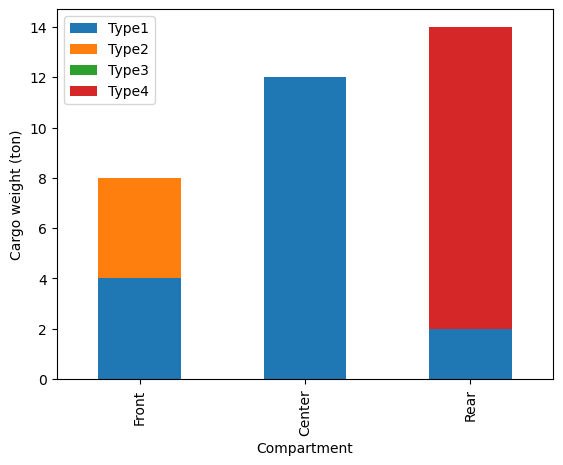

In [41]:
import numpy as np

def plot_results(x, cargo_type, compartment_type):

    results = np.zeros([len(cargo_type), len(compartment_type)])

    for i in range(len(cargo_type)):
      for j in range(len(compartment_type)):
        results[i, j] = x[i, j].X

    optimal_values = pd.DataFrame(results, index=cargo_type, columns=compartment_type)
    ax = optimal_values.transpose().plot.bar(stacked=True)
    ax.set_xlabel('Compartment')
    ax.set_ylabel('Cargo weight (ton)')

plot_results(x, cargo_type, compartment_type)

## Challenges: adding more constraints

Add the following constraints (each one individually) to the model and solve it again:

1) For efficiency purposes the total weight transported in all compartments must be the same.
2) The weight of type I must be double the Type II and III together.
3) The weight of cargo in the frontal area must be at least double the cargo in the rear and central areas together.


## Solutions

### Challenge 1

In [42]:
# 1) For efficiency purposes the total weight transported in all compartments must be the same.

# discard solution information but keep the model
model.reset(1)

model.addConstrs(gp.quicksum(x[i, j+1] for i in range(len(cargo_type)))
                 == gp.quicksum(x[i, j] for i in range(len(cargo_type)))
                 for j in range(len(compartment_type) - 1))

model.update()
model.display()

Discarded solution information including additional information
Maximize
590.0 x[0,0] + 590.0 x[0,1] + 590.0 x[0,2] + 580.0 x[1,0] + 580.0 x[1,1]
+ 580.0 x[1,2] + 580.0 x[2,0] + 580.0 x[2,1] + 580.0 x[2,2] + 600.0 x[3,0]
+ 600.0 x[3,1] + 600.0 x[3,2]
Subject To
  Max available cargo to carry[0]: x[0,0] + x[0,1] + x[0,2] <= 18
  Max available cargo to carry[1]: x[1,0] + x[1,1] + x[1,2] <= 14
  Max available cargo to carry[2]: x[2,0] + x[2,1] + x[2,2] <= 20
  Max available cargo to carry[3]: x[3,0] + x[3,1] + x[3,2] <= 12
  Weight limits on the compartments[0]: x[0,0] + x[1,0] + x[2,0] + x[3,0] <= 8
  Weight limits on the compartments[1]: x[0,1] + x[1,1] + x[2,1] + x[3,1] <= 12
  Weight limits on the compartments[2]: x[0,2] + x[1,2] + x[2,2] + x[3,2] <= 14
Volume limits on the compartments[0]: 180.0 x[0,0] + 250.0 x[1,0] + 300.0 x[2,0] + 80.0
 x[3,0] <= 12000
Volume limits on the compartments[1]: 180.0 x[0,1] + 250.0 x[1,1] + 300.0 x[2,1] + 80.0
 x[3,1] <= 10000
Volume limits on the comp

In [43]:
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 12 rows, 12 columns and 52 nonzeros
Model fingerprint: 0x7559e95d
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [6e+02, 6e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+04]
Presolve removed 2 rows and 0 columns
Presolve time: 0.01s
Presolved: 10 rows, 12 columns, 44 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7540000e+04   3.799100e+01   0.000000e+00      0s
      12    1.4280000e+04   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.428000000e+04


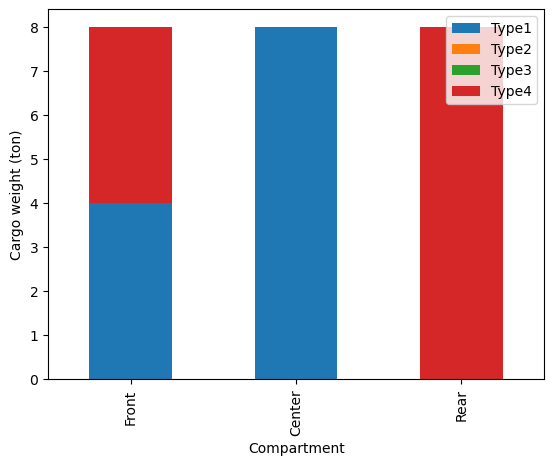

In [44]:
plot_results(x, cargo_type, compartment_type)

### Challenge 2

In [45]:
# discard solution
model.reset(1)
# remove the last two constraints that we added recently
model.remove(model.getConstrs()[-2:])

Discarded solution information including additional information


In [46]:
# 2) The weight of type I must be double the Type II and III together.

model.addConstr(gp.quicksum(x[0, j] for j in range(len(compartment_type)))
                 == 2 * (gp.quicksum(x[1, j] for j in range(len(compartment_type)))
                        + gp.quicksum(x[2, j] for j in range(len(compartment_type)))))

model.update()
model.display()

Maximize
590.0 x[0,0] + 590.0 x[0,1] + 590.0 x[0,2] + 580.0 x[1,0] + 580.0 x[1,1]
+ 580.0 x[1,2] + 580.0 x[2,0] + 580.0 x[2,1] + 580.0 x[2,2] + 600.0 x[3,0]
+ 600.0 x[3,1] + 600.0 x[3,2]
Subject To
  Max available cargo to carry[0]: x[0,0] + x[0,1] + x[0,2] <= 18
  Max available cargo to carry[1]: x[1,0] + x[1,1] + x[1,2] <= 14
  Max available cargo to carry[2]: x[2,0] + x[2,1] + x[2,2] <= 20
  Max available cargo to carry[3]: x[3,0] + x[3,1] + x[3,2] <= 12
  Weight limits on the compartments[0]: x[0,0] + x[1,0] + x[2,0] + x[3,0] <= 8
  Weight limits on the compartments[1]: x[0,1] + x[1,1] + x[2,1] + x[3,1] <= 12
  Weight limits on the compartments[2]: x[0,2] + x[1,2] + x[2,2] + x[3,2] <= 14
Volume limits on the compartments[0]: 180.0 x[0,0] + 250.0 x[1,0] + 300.0 x[2,0] + 80.0
 x[3,0] <= 12000
Volume limits on the compartments[1]: 180.0 x[0,1] + 250.0 x[1,1] + 300.0 x[2,1] + 80.0
 x[3,1] <= 10000
Volume limits on the compartments[2]: 180.0 x[0,2] + 250.0 x[1,2] + 300.0 x[2,2] + 80.0
 

In [47]:
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11 rows, 12 columns and 45 nonzeros
Model fingerprint: 0x0b17eb7b
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [6e+02, 6e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+04]
Presolve removed 2 rows and 0 columns
Presolve time: 0.01s
Presolved: 9 rows, 12 columns, 37 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7540000e+04   2.824100e+01   0.000000e+00      0s
      11    2.0106667e+04   0.000000e+00   0.000000e+00      0s

Solved in 11 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.010666667e+04


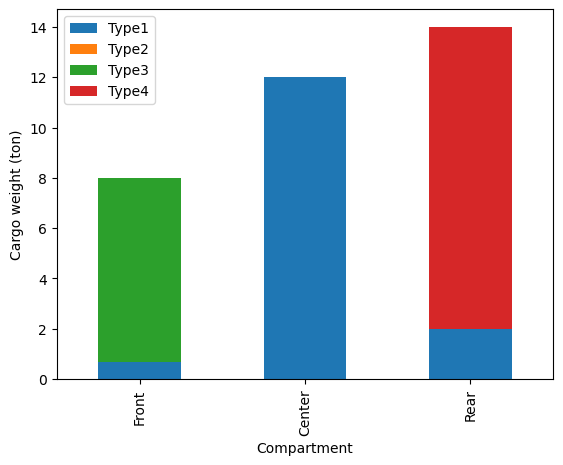

In [48]:
plot_results(x, cargo_type, compartment_type)

### Challenge 3

In [49]:
# discard solution
model.reset(1)
# remove the constraint that we added recently
model.remove(model.getConstrs()[-1])

Discarded solution information including additional information


In [50]:
# 3) The weight of cargo in the frontal area must be at least double the cargo in the rear and central areas together.

model.addConstr(gp.quicksum(x[i, 0] for i in range(len(cargo_type)))
                >= 2 * (gp.quicksum(x[i, 1] for i in range(len(cargo_type))) +
                        gp.quicksum(x[i, 2] for i in range(len(cargo_type))))
)

model.update()
model.display()

Maximize
590.0 x[0,0] + 590.0 x[0,1] + 590.0 x[0,2] + 580.0 x[1,0] + 580.0 x[1,1]
+ 580.0 x[1,2] + 580.0 x[2,0] + 580.0 x[2,1] + 580.0 x[2,2] + 600.0 x[3,0]
+ 600.0 x[3,1] + 600.0 x[3,2]
Subject To
  Max available cargo to carry[0]: x[0,0] + x[0,1] + x[0,2] <= 18
  Max available cargo to carry[1]: x[1,0] + x[1,1] + x[1,2] <= 14
  Max available cargo to carry[2]: x[2,0] + x[2,1] + x[2,2] <= 20
  Max available cargo to carry[3]: x[3,0] + x[3,1] + x[3,2] <= 12
  Weight limits on the compartments[0]: x[0,0] + x[1,0] + x[2,0] + x[3,0] <= 8
  Weight limits on the compartments[1]: x[0,1] + x[1,1] + x[2,1] + x[3,1] <= 12
  Weight limits on the compartments[2]: x[0,2] + x[1,2] + x[2,2] + x[3,2] <= 14
Volume limits on the compartments[0]: 180.0 x[0,0] + 250.0 x[1,0] + 300.0 x[2,0] + 80.0
 x[3,0] <= 12000
Volume limits on the compartments[1]: 180.0 x[0,1] + 250.0 x[1,1] + 300.0 x[2,1] + 80.0
 x[3,1] <= 10000
Volume limits on the compartments[2]: 180.0 x[0,2] + 250.0 x[1,2] + 300.0 x[2,2] + 80.0
 

In [51]:
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11 rows, 12 columns and 48 nonzeros
Model fingerprint: 0xd5032217
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [6e+02, 6e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+04]
Presolve removed 2 rows and 0 columns
Presolve time: 0.00s
Presolved: 9 rows, 12 columns, 40 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7540000e+04   2.199100e+01   0.000000e+00      0s
       9    7.2000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.200000000e+03


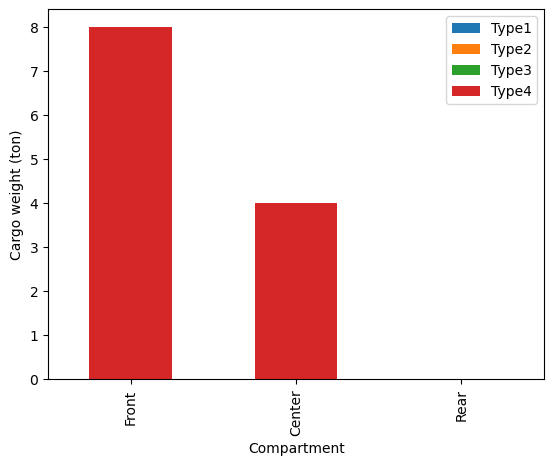

In [52]:
plot_results(x, cargo_type, compartment_type)